# Get mF1 scores for each of the identity intervals  

In [6]:
# define the directory where the data is
data_path = "/home/jcapela/ec_numbers_prediction/required_data_ec_number_paper"

In [7]:
import pandas as pd

not_in_predictions = pd.read_csv(f"{data_path}/not_in_predictions.csv")
predictions = pd.read_csv(f"{data_path}/predictions_no_duplicates_ident_evalue.csv")
test_dataset_pandas = pd.read_csv(f"{data_path}/data/test.csv")

/tmp/ipykernel_1827633/1775222236.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  test_dataset_pandas = pd.read_csv(f"{data_path}/data/test.csv")


In [8]:
blast_results = pd.read_csv(f"{data_path}/test_blast_predictions_right_format.csv")
blast_results_true_values = pd.read_csv(f"{data_path}/test_right_format.csv")

/tmp/ipykernel_1827633/2845153967.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results = pd.read_csv(f"{data_path}/test_blast_predictions_right_format.csv")
/tmp/ipykernel_1827633/2845153967.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results_true_values = pd.read_csv(f"{data_path}/test_right_format.csv")


## Function to get the predictions for the enzymes below a specific identity threshold

In [9]:
from plants_sm.data_structures.dataset.single_input_dataset import SingleInputDataset
from plants_sm.models.pytorch_model import PyTorchModel
from sklearn.metrics import f1_score
import numpy as np

def get_less_studied_predictions(model, model_path, evalue_threshold=1e-5, identity_threshold1=None, identity_threshold2=None, 
                                 return_blast_results=True,
                                features_path=None):
    
    if features_path is None:
        features_path = f'{data_path}/features/test_{model}/'
    
    if identity_threshold1 is None:
        high_evalue_predictions = predictions[predictions["evalue"]>evalue_threshold].qseqid.tolist()
        high_evalue_predictions.extend(not_in_predictions.qseqid.tolist())
        print(len(high_evalue_predictions))
    elif identity_threshold2 is None:
        high_evalue_predictions = predictions[predictions["pident"]<identity_threshold1].qseqid.tolist()
        high_evalue_predictions.extend(not_in_predictions.qseqid.tolist())
        print(len(high_evalue_predictions))
    else:
        high_evalue_predictions = predictions[(predictions["pident"]<=identity_threshold1) & (predictions["pident"]>identity_threshold2)].qseqid.tolist()
        high_evalue_predictions.extend(not_in_predictions.qseqid.tolist())
        print(len(high_evalue_predictions))
    
    test_dataset_pandas_filtered = test_dataset_pandas[test_dataset_pandas["accession"].isin(high_evalue_predictions)]
    test_dataset_no_similarity = SingleInputDataset(test_dataset_pandas_filtered,
                                            instances_ids_field="accession", representation_field="sequence",
                                            labels_field=slice(8, 2779))
    print("loading features...")
    test_dataset_no_similarity.load_features(features_path)

    blast_results_no_similarity = blast_results[blast_results["qseqid"].isin(high_evalue_predictions)]
    blast_results_true_values_no_similarity = blast_results_true_values[blast_results_true_values["accession"].isin(high_evalue_predictions)]

    predictions_blast = blast_results_no_similarity.iloc[:, 6:]
    true_values = blast_results_true_values_no_similarity.iloc[:, 8:]

    def get_labels_to_remove(dataset):
        labels_with_no_positive_sample = []
        for i in range(dataset.shape[1]):
            if dataset[:, i].sum() == 0:
                labels_with_no_positive_sample.append(i)
        return labels_with_no_positive_sample

    labels_to_remove = get_labels_to_remove(np.array(true_values))

    predictions_blast = np.delete(np.array(predictions_blast), labels_to_remove, axis=1)
    true_values = np.delete(np.array(true_values), labels_to_remove, axis=1)

    results = {}
    
    if return_blast_results:
        print("BLAST")
        blast_wf1 = f1_score(true_values, predictions_blast, average="weighted")
        blast_mf1 = f1_score(true_values, predictions_blast, average="macro")
        print(blast_mf1)
        print(blast_wf1)

    else:
        blast_mf1 = None
        blast_wf1 = None
    
    print("loading model...")

    pytorch_model = PyTorchModel.load(model_path)
    
    print("predicting...")
    predictions_esm2_3b_no_similarity = pytorch_model.predict(test_dataset_no_similarity)
    # drop columns with only zeros
    
    labels_to_remove = get_labels_to_remove(test_dataset_no_similarity.y)

    predictions_esm2_3b_no_similarity_ = np.delete(predictions_esm2_3b_no_similarity, labels_to_remove, axis=1)
    y_true = np.delete(test_dataset_no_similarity.y, labels_to_remove, axis=1)
    print("Model")
    mf1 = f1_score(y_true, predictions_esm2_3b_no_similarity_, average="macro")
    print(mf1)
    wf1 = f1_score(y_true, predictions_esm2_3b_no_similarity_, average="weighted")
    print(wf1)
    return mf1, wf1, len(high_evalue_predictions), blast_mf1, blast_wf1
    

## Get the results for each of the identity intervals for ESM and ProtBERT models

In [10]:
model = "esm2_t36_3B_UR50D"
model_path = f"{data_path}/models/DNN_esm2_t36_3B_UR50D_trial_2_merged"


models = [("esm2_3b", f"{data_path}/models/DNN_esm2_t36_3B_UR50D_trial_2_merged"), 
          ("prot_bert", f"{data_path}/models/DNN_prot_bert_vectors_trial_2_merged"), 
          ("esm1b", f"{data_path}/models/DNN_esm1b_t33_650M_UR50S_trial_4_merged")]

results = {}
thresholds = [0, 15, 25, 35, 45, 55, 65, 75, 85, 90, 100]
#thresholds = [90, 100]


for model, model_path in models:
    for i in range(1, len(thresholds)):

        identity_threshold1 = thresholds[i]
        identity_threshold2 = thresholds[i-1]
        print(f"identity {identity_threshold1}")
        mf1, wf1, samples_num, _, _ = get_less_studied_predictions(model, model_path,
                                    identity_threshold1=identity_threshold1,
                                    identity_threshold2=identity_threshold2, return_blast_results=False)
        
        if "method" not in results:
            results["method"] = [model]
        else:
            results["method"].append(model)
        
        if "identity_threshold" not in results:
            results["identity_threshold"] = [identity_threshold1]
        else:
            results["identity_threshold"].append(identity_threshold1)

        if "macro_f1" not in results:
            results["macro_f1"] = [mf1]
        else:
            results["macro_f1"].append(mf1)

        if "weighted_f1" not in results:
            results["weighted_f1"] = [wf1]

        else:
            results["weighted_f1"].append(wf1)

        if "samples_num" not in results:
            results["samples_num"] = [samples_num]
        else:
            results["samples_num"].append(samples_num)

pd.DataFrame(results).to_csv("less_studied_results.csv", index=False)

identity 15
638
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.2148522600069172
0.4844746428478084
identity 25
803
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.30668014997372667
0.5684482127710454
identity 35
3130


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.5559539211287297
0.7936932274806474
identity 45
6301
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.720259530282053
0.8839718291456056
identity 55
9387
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.8079824864216469
0.9257551928272099
identity 65
12520


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8646140378093807
0.9492928059142338
identity 75
15027


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8936438100026236
0.9622494503331225
identity 85
17298


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.9154057513691208
0.9711429694900247
identity 90
9597
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.9175985474955451
0.9652628168740848
identity 100
6607
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.8843843199413001
0.9479866294530929
identity 15
638
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.1572773471788706
0.402127474347197
identity 25
803


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.2341347892332234
0.4820522628213456
identity 35
3130
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.5041584007595796
0.744363088181959
identity 45
6301
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.694866629418101
0.8542713185093047
identity 55
9387


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.7921764546083326
0.9095201909786844
identity 65
12520


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8570349899053203
0.9396157944638097
identity 75
15027


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8858098929594709
0.9551008469477251
identity 85
17298


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.9140632676118641
0.9650358972745868
identity 90
9597


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.9057328665971867
0.9584595013146066
identity 100
6607
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.8701012483459691
0.9365675261463771
identity 15
638
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.19729535354318428
0.46919112427280985
identity 25
803


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.28150325749513067
0.5512579214208669
identity 35
3130
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.5541990908453408
0.7910706341268265
identity 45
6301
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.7102169557521324
0.8774983059237336
identity 55
9387
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.8031553937693615
0.9231721326705039
identity 65
12520


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8543384671046127
0.946335159099611
identity 75
15027


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.8869928597984092
0.9601511355621517
identity 85
17298


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.9124226801715539
0.9695585802705129
identity 90
9597


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading features...
loading model...
predicting...
Model
0.9131863678909414
0.9639909648988467
identity 100
6607
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...
Model
0.8784422827420547
0.9450901262783955


## Get the results for each of the identity intervals for DeepEC and DSPACE models

In [11]:
model = "esm2_t36_3B_UR50D"
model_path = f"{data_path}/models/DNN_esm2_t36_3B_UR50D_trial_2_merged"


models = [("DeepEC", "one_hot", f"{data_path}/models/DeepEC_merged_merged"), 
          ("DSPACE", "one_hot", f"{data_path}/models/DSPACE_merged_merged") 
         ]

thresholds = [0, 15, 25, 35, 45, 55, 65, 75, 85, 90, 100]
#thresholds = [90, 100]

def f1_score_macro():
    pass

results = {}
for model_name,model, model_path in models:
    for i in range(1, len(thresholds)):

        identity_threshold1 = thresholds[i]
        identity_threshold2 = thresholds[i-1]
        print(f"identity {identity_threshold1}")
        mf1, wf1, samples_num, _, _ = get_less_studied_predictions(model, model_path,
                                    identity_threshold1=identity_threshold1,
                                    identity_threshold2=identity_threshold2, return_blast_results=False,
                                    features_path=f'{data_path}/features/test_one_hot/')
        
        if "method" not in results:
            results["method"] = [model_name]
        else:
            results["method"].append(model_name)
        
        if "identity_threshold" not in results:
            results["identity_threshold"] = [identity_threshold1]
        else:
            results["identity_threshold"].append(identity_threshold1)

        if "macro_f1" not in results:
            results["macro_f1"] = [mf1]
        else:
            results["macro_f1"].append(mf1)

        if "weighted_f1" not in results:
            results["weighted_f1"] = [wf1]

        else:
            results["weighted_f1"].append(wf1)

        if "samples_num" not in results:
            results["samples_num"] = [samples_num]
        else:
            results["samples_num"].append(samples_num)
            
pd.read_csv("less_studied_results.csv").append(pd.DataFrame(results)).to_csv("less_studied_results.csv", index=False)

identity 15
638
loading features...


/home/jcapela/miniconda3/envs/ec_number_prediction/lib/python3.9/site-packages/plants_sm/data_structures/dataset/single_input_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe.drop(self.representation_field, axis=1, inplace=True)


loading model...
predicting...


: 

## Get the results for each of the identity intervals for BLASTp

In [ ]:
model = "esm2_t36_3B_UR50D"
model_path = f"{data_path}/models/DNN_esm2_t36_3B_UR50D_trial_2_merged"

less_studied_enzymes = pd.read_csv("less_studied_results.csv")

results = {}
thresholds = [0, 15, 25, 35, 45, 55, 65, 75, 85, 90, 100]
for i in range(1, len(thresholds)):
    identity_threshold1 = thresholds[i]
    identity_threshold2 = thresholds[i-1]
    mf1, wf1, samples_num, blast_mf1_score, blast_wf1_score = get_less_studied_predictions(model, model_path,
                                        identity_threshold1=identity_threshold1,
                                        identity_threshold2=identity_threshold2, return_blast_results=True)
    if "method" not in results:
        results["method"] = ["BLASTp"]
    else:
        results["method"].append("BLASTp")

    if "identity_threshold" not in results:
        results["identity_threshold"] = [identity_threshold1]
    else:
        results["identity_threshold"].append(identity_threshold1)

    if "macro_f1" not in results:
        results["macro_f1"] = [blast_mf1_score]
    else:
        results["macro_f1"].append(blast_mf1_score)
    
    if "weighted_f1" not in results:
        results["weighted_f1"] = [blast_wf1_score]
    else:
        results["weighted_f1"].append(blast_wf1_score)
    
    if "samples_num" not in results:
        results["samples_num"] = [samples_num]
    else:
        results["samples_num"].append(samples_num)


## Get the results for each of the identity intervals for the ensemble of models and BLASTp

### Note that the predictions were already saved in a pickle file

In [ ]:
import pickle

with open(f"{data_path}/predictions/predictions_models_voting.pkl", "rb") as f:
    voting_predictions = pickle.load(f)

# read predictions from pickle file
import pickle

with open(f"{data_path}/predictions/predictions_models_voting_blast.pkl", "rb") as f:
    voting_predictions_blast = pickle.load(f)

In [ ]:
results = {}
thresholds = [0, 15, 25, 35, 45, 55, 65, 75, 85, 90, 100]
#thresholds = [90, 100]

for method in ["Models + BLASTp ensemble", "Models ensemble"]:
    for i in range(1, len(thresholds)):

        if method == "Models ensemble":
            voting_predictions_ = voting_predictions
        else:
            voting_predictions_ = voting_predictions_blast

        identity_threshold1 = thresholds[i]
        identity_threshold2 = thresholds[i-1]
        print(f"identity {identity_threshold1}")
        mf1, samples_num = get_less_studied_predictions(voting_predictions_,
                                    identity_threshold1=identity_threshold1,
                                    identity_threshold2=identity_threshold2)

        if "method" not in results:
            results["method"] = [method]
        else:
            results["method"].append(method)
        
        if "identity_threshold" not in results:
            results["identity_threshold"] = [identity_threshold1]
        else:
            results["identity_threshold"].append(identity_threshold1)

        if "macro_f1" not in results:
            results["macro_f1"] = [mf1]
        else:
            results["macro_f1"].append(mf1)

        if "samples_num" not in results:
            results["samples_num"] = [samples_num]
        else:
            results["samples_num"].append(samples_num)
            
pd.read_csv("less_studied_results.csv").append(pd.DataFrame(results)).to_csv("less_studied_results.csv", index=False)

## Save them to the csv file

In [ ]:
less_studied_enzymes.append(pd.DataFrame(results)).to_csv("less_studied_results.csv", index=False)

## Plot the results

Note that the name of the models were changed in the dataset directly to make the plot more readable.

In [ ]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'DSPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp ensemble': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

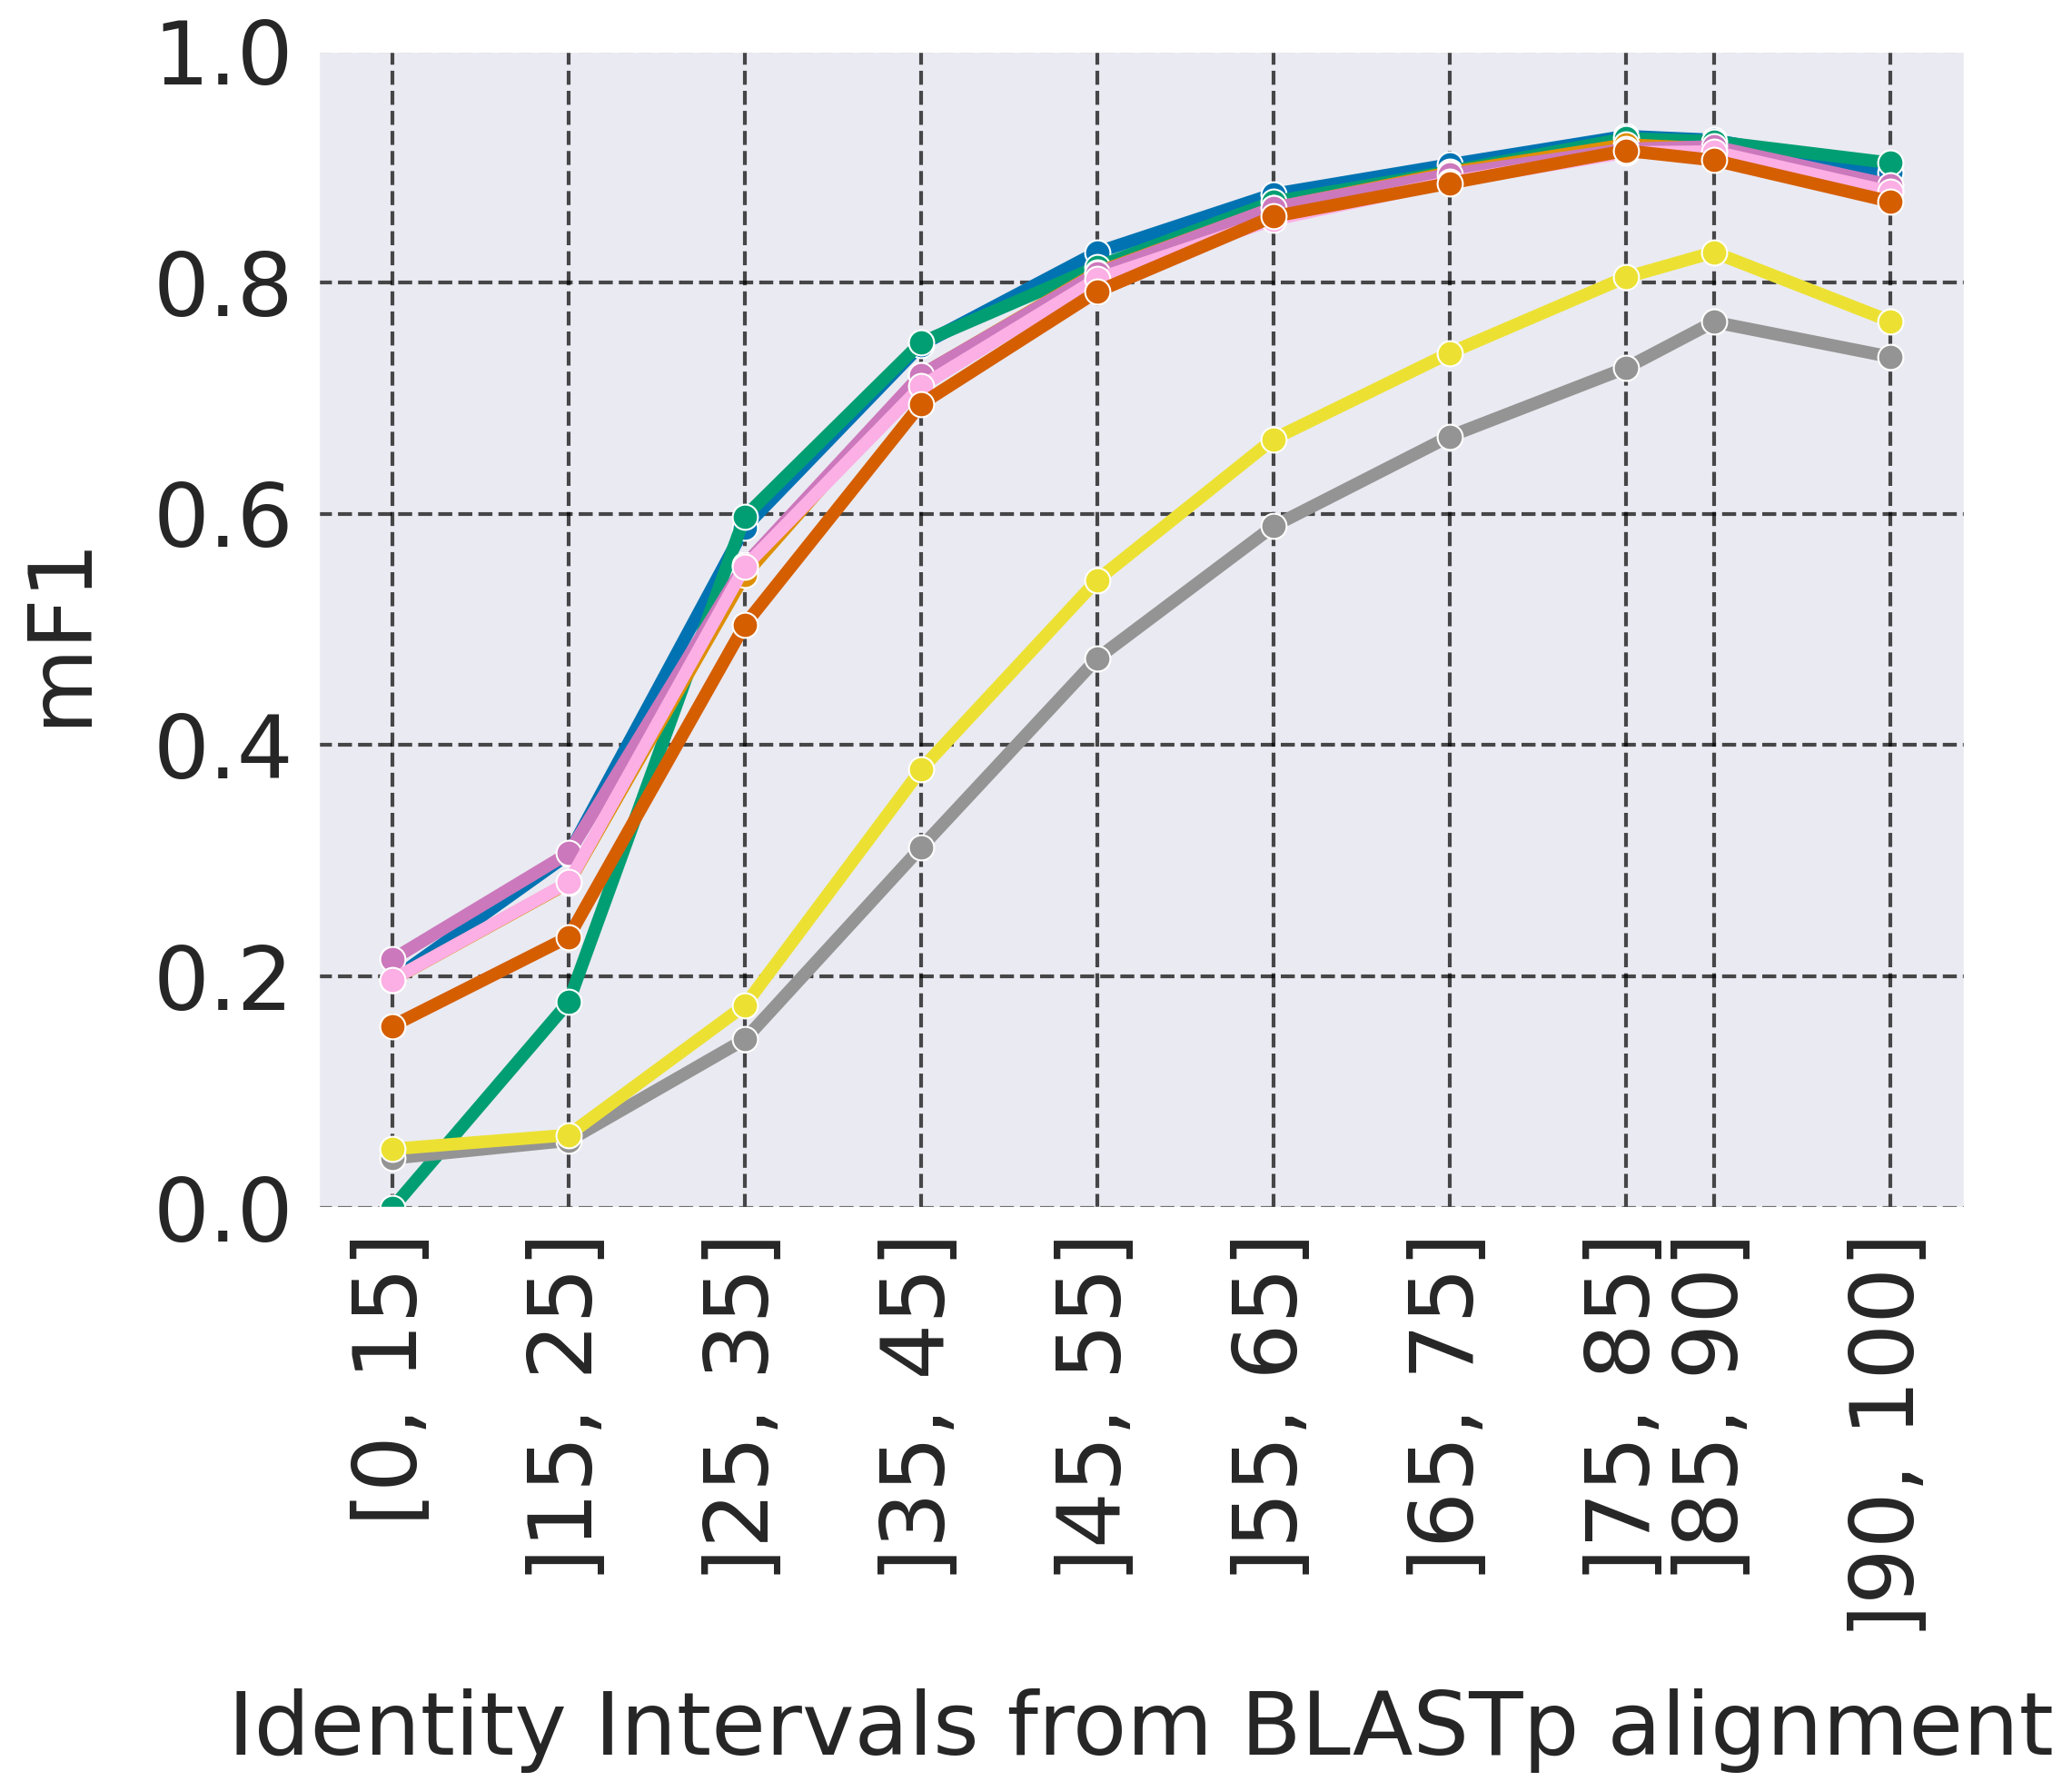

In [ ]:
import pandas as pd
import numpy as np

less_studied_enzymes = pd.read_csv("less_studied_results.csv")

# generate line plot for f1 score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True

# Set Seaborn style
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Plotting with Seaborn
plt.figure(figsize=(11.7, 8.27))
sns.lineplot(x='identity_threshold', y='macro_f1', hue='method', marker='o',  markers=True, markersize=10, data=less_studied_enzymes, palette=color_map,
            linewidth=5, legend=False)

# plt.title('mF1 per Identity Intervals')
plt.xlabel('Identity Intervals from BLASTp alignment', labelpad=20, fontsize=35)
plt.ylabel('mF1', labelpad=20, fontsize=35)
#plt.legend(title='Method')
plt.ylim(0, 1, 0.1)
thresholds = [0, 15, 25, 35, 45, 55, 65, 75, 85, 90, 100]
labels = []
for i in range(1, len(thresholds)):
    if i == 1:
        labels.append(f"[{thresholds[i-1]}, {thresholds[i]}]")
    else:
        labels.append(f"]{thresholds[i-1]}, {thresholds[i]}]")

# Adjust tick parameters
plt.tick_params(axis='both', which='major', labelsize=35)
plt.xticks([15, 25, 35, 45, 55, 65, 75, 85, 90, 100], labels=labels, rotation=90)
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['figure.dpi'] = 200
#plt.title("mF1 per Identity Intervals from BLASTp alignment", pad=40, fontsize=23)
# plt.show()
# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.5, color='black')
plt.savefig("mF1_per_identity_intervals.png", bbox_inches='tight', dpi=400)